In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

from ssm import LDS
from ssm.util import random_rotation

# Set the parameters of the HMM
T = 1000   # number of time bins
D = 2      # number of latent dimensions
N = 10     # number of observed dimensions

# Make an LDS with somewhat interesting dynamics parameters
true_lds = LDS(N, D, emissions="gaussian")
A0 = .99 * random_rotation(D, theta=np.pi/20)
# S = (1 + 3 * npr.rand(D))
S = np.arange(1, D+1)
R = np.linalg.svd(npr.randn(D, D))[0] * S
A = R.dot(A0).dot(np.linalg.inv(R))
b = npr.randn(D)
true_lds.dynamics.As[0] = A
true_lds.dynamics.bs[0] = b

Fitting LDS with Laplace EM


  0%|          | 0/10 [00:00<?, ?it/s]

(0.0, 200.0)

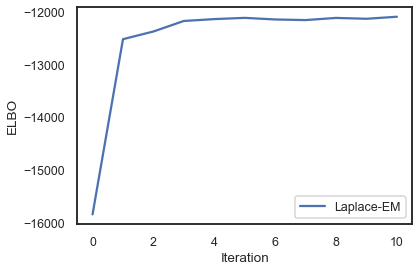

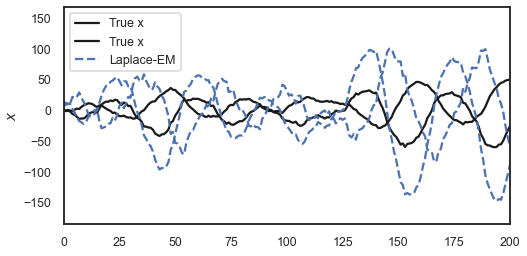

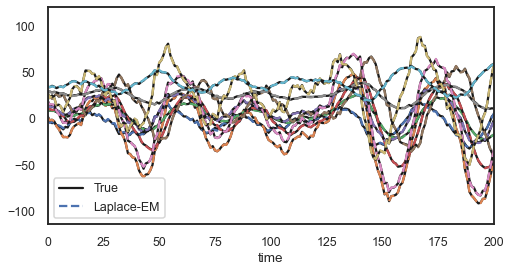

In [50]:
# print("Fitting LDS with SVI")

# # Create the model and initialize its parameters
# lds = LDS(N, D, emissions="gaussian")
# lds.initialize(y)
# q_mf_elbos, q_mf = lds.fit(y, method="bbvi", variational_posterior="mf", 
#                            num_iters=5000, stepsize=0.1, initialize=False)
# # Get the posterior mean of the continuous states
# q_mf_x = q_mf.mean[0]
# # Smooth the data under the variational posterior
# q_mf_y = lds.smooth(q_mf_x, y)


# print("Fitting LDS with SVI using structured variational posterior")
# lds = LDS(N, D, emissions="gaussian")
# lds.initialize(y)
# q_struct_elbos, q_struct = lds.fit(y, method="bbvi", 
#                                    variational_posterior="lds", 
#                                    num_iters=2000, stepsize=0.1, initialize=False)
# # Get the posterior mean of the continuous states
# q_struct_x = q_struct.mean[0]
# # Smooth the data under the variational posterior
# q_struct_y = lds.smooth(q_struct_x, y)

print("Fitting LDS with Laplace EM")
lds = LDS(N, D, emissions="gaussian")
lds.initialize(y) # adds data 

# fits A/B/C/D/x
q_lem_elbos, q_lem = lds.fit(y, method="laplace_em", 
                             variational_posterior="structured_meanfield",
                             num_iters=10, initialize=False)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Smooth the data under the variational posterior
q_lem_y = lds.smooth(q_lem_x, y)

# Plot the ELBOs
plt.figure()
# plt.plot(q_mf_elbos, label="MF")
# plt.plot(q_struct_elbos, label="LDS")
plt.plot(q_lem_elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k', label='True x')
colors = ['r', 'g','b']
for d in range(D):
    #plt.plot(q_mf_x[:,d] + 4 * d, '-', color=colors[0], label="MF" if d==0 else None)
    #plt.plot(q_struct_x[:,d] + 4 * d, ':', color=colors[1], label="Struct" if d==0 else None)
    plt.plot(q_lem_x[:,d] + 4 * d, '--', color=colors[2], label="Laplace-EM" if d==0 else None)
plt.ylabel("$x$")
plt.xlim((0,200))
plt.legend()

# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(y[:, n] + 4 * n, '-k', label="True" if n == 0 else None)
    #plt.plot(q_mf_y[:, n] + 4 * n, '--', color=colors[0], label="MF" if n == 0 else None)
    #plt.plot(q_struct_y[:, n] + 4 * n, ':',  color=colors[1], label="Struct" if n == 0 else None)
    plt.plot(q_lem_y[:, n] + 4 * n, '--', label="Laplace-EM" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.xlim((0,200))

In [2]:
import ssm

In [6]:
# Simulate the nascar data
def make_nascar_model(D_latent, D_obs, K):
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))

    true_rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))

    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r

    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds



In [54]:
#init, trans, dyn, em = true_rslds.params

In [62]:
#z, x, y = true_rslds.sample()

In [7]:
true_rslds = make_nascar_model(2, 10, 4)
z2, x2, y2 = true_rslds.sample(T=T)
z, x, y = true_rslds.sample(T=T)


In [8]:
### See if 'approx_variational' posterior actually updates / fits the posterior 
rslds_lem = ssm.SLDS(10, 4, 2,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)

# # Initialize the model with the observed data.  It is important
# # to call this before constructing the variational posterior since
# # the posterior constructor initialization looks at the rSLDS parameters.
rslds_lem.initialize(y)

q_elbos_lem, q_lem = rslds_lem.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=10, alpha=0.0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
### now test the individual steps in approximate_posterior 

# Initialize the variational posterior

variational_posterior = 'structured_meanfield'
datas = [y2]; 
inputs = None; masks = None; tags = None; method = 'laplace_em'
posterior = rslds_lem._make_variational_posterior(variational_posterior, datas, inputs, masks, tags, method)
print(posterior.mean_continuous_states[0])

# Update the variational posterior 
inputs = [np.zeros((1000, 0))]
masks = [np.ones_like(datas[0], dtype=np.bool)] 
tags = [np.zeros((1000, 0))]

elbos = rslds_lem._fit_laplace_em(posterior, datas, inputs=inputs, masks=masks, tags=tags,
                                   learning=False, num_iters=10)
print(posterior.mean_continuous_states[0])

[[-0.26143554 -0.88168749]
 [-0.37666219 -0.93835875]
 [-0.40370992 -0.99811213]
 ...
 [ 1.83140204 -0.7331431 ]
 [ 1.782078   -0.66623291]
 [ 1.63472224 -0.9497606 ]]


  0%|          | 0/10 [00:00<?, ?it/s]

[[-0.26254912 -0.91977846]
 [-0.36189453 -0.95876912]
 [-0.45663396 -1.0046993 ]
 ...
 [ 1.82406342 -0.72838552]
 [ 1.73157856 -0.75372344]
 [ 1.61825033 -0.80585935]]


In [13]:
masks

[array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])]

In [13]:
x=np.zeros((1000, 0))

In [14]:
x

array([], shape=(1000, 0), dtype=float64)

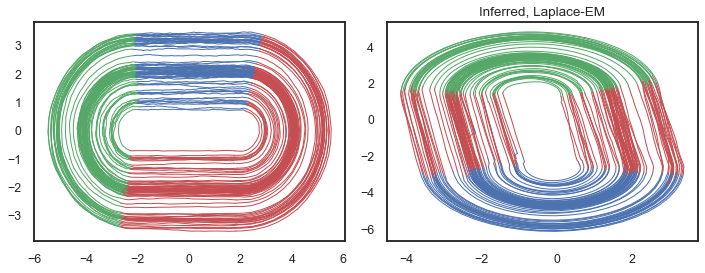

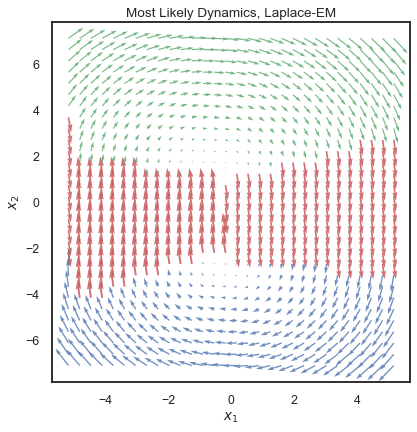

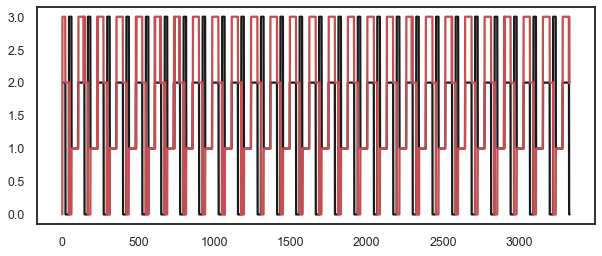

In [77]:
T = 10000
K = 4
D_obs = 10
D_latent = 2

# # # Sample from the model
# true_rslds = make_nascar_model(D_latent, D_obs, K)
# z, x, y = true_rslds.sample(T=T)
# z2, x2, y2 = true_rslds.sample(T=T)

# # # Fit a robust rSLDS with its default initialization
# #
# # # Fit with Laplace EM
# rslds_lem = ssm.SLDS(D_obs, K, D_latent,
#              transitions="recurrent_only",
#              dynamics="diagonal_gaussian",
#              emissions="gaussian_orthog",
#              single_subspace=True)

# # # Initialize the model with the observed data.  It is important
# # # to call this before constructing the variational posterior since
# # # the posterior constructor initialization looks at the rSLDS parameters.
# rslds_lem.initialize(y)

# q_elbos_lem, q_lem = rslds_lem.fit(y, method="laplace_em",
#                                variational_posterior="structured_meanfield",
#                                initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
zhat_lem = rslds_lem.most_likely_states(xhat_lem, y)

# Plot some results
plt.figure(figsize=[10,4])
ax1 = plt.subplot(121)
plot_trajectory(z, x, ax=ax1)
ax2 = plt.subplot(122)
plot_trajectory(zhat_lem, xhat_lem, ax=ax2)
plt.title("Inferred, Laplace-EM")
plt.tight_layout()

plt.figure(figsize=(6,6))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Most Likely Dynamics, Laplace-EM")

plt.show()

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(111)
ax1.plot(z[:int(T/3)], 'k-')
ax1.plot(zhat_lem[:int(T/3)], 'r-')



In [81]:
Cs = q_lem.model.emissions.Cs
ds = q_lem.model.emissions.ds; 

ds.shape

(1, 10)

In [82]:
t = 3
ds[0, t-1:t+1]

array([-0.53978105,  0.3849664 ])

In [83]:
M=(0, )
D = (2, )
T = 10000

In [122]:
input = np.zeros((T+1,) + M) 
xmask = np.ones((T+1,) + D, dtype=bool)

In [127]:
y.shape

(10000, 10)

In [130]:
Pt = rslds_lem.transitions.log_transition_matrices(x[:2, :], input[:2, :], xmask[:2, :], None)

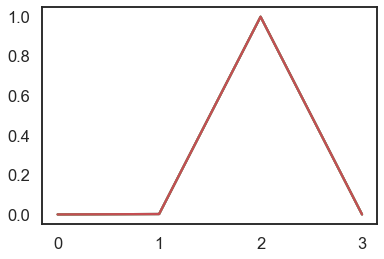

In [135]:
plt.plot(np.exp(Pt[0, :, :].T))

In [193]:
x=hmm_filter(prms["pi0"], prms["Ps"], prms["log_likes"])

In [203]:
x_filt

[(4921051.490700874,
  array([[[ 1.01113330e+02,  2.01584496e-01],
          [ 2.01584496e-01,  1.02237633e+02]],
  
         [[ 2.01813104e+02, -3.04226313e-01],
          [-3.04226313e-01,  2.05937577e+02]],
  
         [[ 3.01236832e+02, -2.67843358e+00],
          [-2.67843358e+00,  3.06589120e+02]],
  
         ...,
  
         [[ 7.39049786e+02, -3.73082875e+01],
          [-3.73082875e+01,  9.16570105e+02]],
  
         [[ 7.42346297e+02, -2.88531550e+01],
          [-2.88531550e+01,  9.28591438e+02]],
  
         [[ 7.45082153e+02, -2.23678777e+01],
          [-2.23678777e+01,  9.38617080e+02]]]),
  array([[ -236.21973335,    -3.06567332],
         [ -488.42873485,     6.30019765],
         [ -745.25935021,   -51.00600005],
         ...,
         [-1708.10347845,  -384.10455704],
         [-1795.61416338,  -358.77014296],
         [-1875.98934178,  -332.25503446]]))]

In [232]:
# Now lets get x-estimates 
x_filt = [kalman_info_filter(prms["J_ini"], prms["h_ini"], 0,
                                  prms["J_dyn_11"], prms["J_dyn_21"], prms["J_dyn_22"],
                                  prms["h_dyn_1"], prms["h_dyn_2"], 0,
                                  prms["J_obs"], prms["h_obs"], 0)
             for prms in q_lem_new._continuous_state_params]

In [234]:
smoothed_Sigmas = [np.linalg.inv(xf[1]) for xf in x_filt]


In [283]:
prms = q_lem_new._continuous_state_params[0]

In [285]:
prms["J_dyn_11"].shape

(9999, 2, 2)

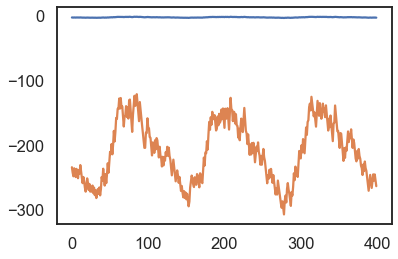

In [270]:
plt.plot(mu[:400, 0])
plt.plot(prms['h_obs'][:400, 0])

In [ ]:
q_lem_new.est

In [276]:
### ok lets see how far we get with noiseless predictions ### 
from ssm.messages import kalman_info_filter, forward_pass, logsumexp, hmm_filter, hmm_expected_states

# q_lem is the posterior -- with learned parameters from previous data 
# now lets get the posterior for new data 

### New approx posterior 
_, q_lem_new = rslds_lem.approximate_posterior(y2, inputs=None)

### Get x0 from this estimate 
x0 = q_lem_new.mean_continuous_states[0]
# Now lets get z-estimates
z_filt = []
for prms in q_lem_new._discrete_state_params:
    pz_tp1t = hmm_filter(prms["pi0"], prms["Ps"], prms["log_likes"])
    #pz_tp1t, _, _ = hmm_expected_states(prms["pi0"], prms["Ps"], prms["log_likes"])
    z_filt.append(np.argmax(pz_tp1t, axis=1))

# Now lets get x-estimates 
x_filt = [kalman_info_filter(prms["J_ini"], prms["h_ini"], 0,
                                  prms["J_dyn_11"], prms["J_dyn_21"], prms["J_dyn_22"],
                                  prms["h_dyn_1"], prms["h_dyn_2"], 0,
                                  prms["J_obs"], prms["h_obs"], 0)
             for prms in q_lem_new._continuous_state_params]


# Convert info form to mean parameters
mu = []; 
for x_filt_i in x_filt:
    for t in range(x_filt_i[2].shape[0]): 
        ss = np.linalg.inv(x_filt_i[1][t, :, :])
        mu.append(np.dot(ss, x_filt_i[2][t, :]))
mu = np.vstack((mu))

mu2 = []
prms = q_lem_new._continuous_state_params[0]
for t in range(prms["h_obs"].shape[0]): 
    ss = np.linalg.inv(prms["J_obs"][t, :, :])
    mu2.append(np.dot(ss, prms["h_obs"][t, :]))
mu2 = np.vstack((mu2))

# Cs = q_lem.model.emissions.Cs
# ds = q_lem.model.emissions.ds; 

# ### See if we can Kalman filter: 
# for t in range(1, 5):
    
#     ### Get next z: (z_{t+1} | x_t)
#     xi = np.vstack(( xt[np.newaxis, :], np.zeros((1, xt.shape[0])) ))
#     ii = np.zeros((xi.shape[0], 0))
#     Pt = rslds_lem.transitions.log_transition_matrices(xi, ii, None, None)
    
#     z_tp1 = np.argmax(Pt[0, 0, :])
    
#     #### Get A / b based on z_next ### 
#     A = q_lem.model.dynamics.As[z_tp1, :, :]
#     b = q_lem.model.dynamics.bs[z_tp1, :]
    
#     ### Predict x_{t+1} | y_{t}
#     x_tp1 = np.dot(A, xt[:, np.newaxis]) + b.T
    
#     ### Estimated next y_{t+1} | y_{t}
#     y_pred.append(np.dot(Cs, x_tp1) + ds.T)
    
#     ### Now do the observation update: x_{t+1} | y_{t+1}
xhat_lem = q_lem_new.mean_continuous_states[0]
zhat_lem = rslds_lem.most_likely_states(xhat_lem, y2)




In [282]:
q_lem_new.model.dynamics.Sigmas.shape

(4, 2, 2)

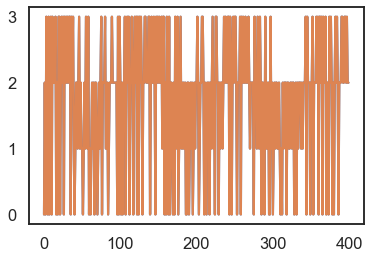

In [280]:
plt.plot(zhat_lem[:400])
prms = q_lem_new._discrete_state_params[0]
ll = prms["log_likes"]
plt.plot(np.argmax(ll, axis=1)[:400])


In [ ]:
plt.plot(zhat_lem)
plt.plot(z_filt[0])

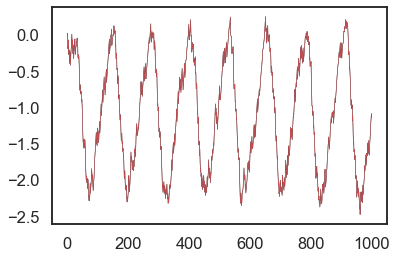

In [277]:
plt.plot(mu2[:1000, 1], 'k-', linewidth=.5)
plt.plot(mu[:1000, 1], 'r-', linewidth=.5)

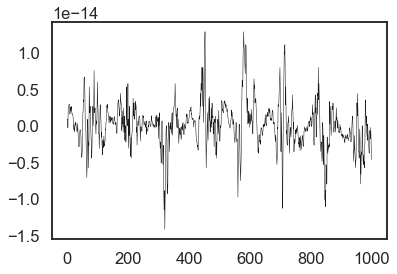

In [245]:
plt.plot(xhat_lem[:1000, 1]-mu[:1000, 1], 'k-', linewidth=.5)

In [183]:
# plt.pcolormesh(np.exp(q_lem_new._discrete_state_params[0]['Ps'][:, 0, :]))

In [180]:
# q_lem_new._discrete_state_params[0]['Ps'][0, 0, :]

array([6.46442792e-15, 7.38898748e-01, 2.26189673e-01, 3.49115790e-02])

In [184]:
# plt.pcolormesh(q_lem_new._discrete_state_params['Ps']

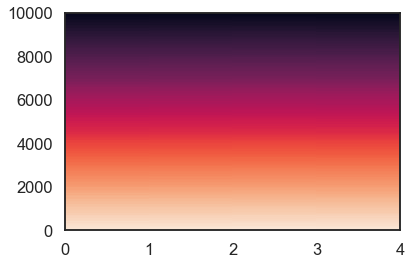

In [168]:
q_lem.model.dynamics.bs

array([[-0.06299305, -0.07059093],
       [ 0.2273882 , -0.11616047],
       [-0.08878526,  0.04530726],
       [ 0.081058  ,  0.33810769]])

In [51]:
rslds_lem.smooth?

In [76]:
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)

    return ax

def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=30, nypts=30,
    alpha=0.8, ax=None, figsize=(3, 3)):

    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    log_Ps = model.transitions.log_transition_matrices(
        xy, np.zeros((nxpts * nypts, 0)), np.ones_like(xy, dtype=bool), None)
    z = np.argmax(log_Ps[:, 0, :], axis=-1)
    z = np.concatenate([[z[0]], z])

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax


In [7]:
import ssm
### Sample from it
T = 1000   # number of time bins
D_latent = 2      # number of latent dimensions
D_obs = 10     # number of observed dimensions
D_input = 0
K = 4

### Make the nascar model ### 
true_rslds = make_nascar_model(D_latent, D_obs, K)


z, x, y = true_rslds.sample(T=T)
z2, x2, y2 = true_rslds.sample(T=T)

### Now try to fit it; 
## Recurrent-only means: p(z_{t+1} | x_t, z_t) = p(z_{t+1} | x_t) --> x_t fully determines z_{t+1}
## Diagonal gaussian -- noise? 
## Gaussian_orthog -- ? 
## Single subspace --> each dynaical system has the same x-->y mapping (i.e. 1 C, d, not many)
rslds_lem = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)

# # Initialize the model with the observed data.  It is important
# # to call this before constructing the variational posterior since
# # the posterior constructor initialization looks at the rSLDS parameters.
rslds_lem.initialize(y)

# # Fit the model with "y" data
q_elbos_lem, q_lem = rslds_lem.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=1000, alpha=0.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
### ok lets see how we can do a filtered prediction ## 
# q_lem is the posterior -- with parameters used in it learned from previous data "y"
# lets compare smoothed x fit by the model to filtered x
xhat_smooth_lem = q_lem.mean_continuous_states[0]
zhat_smooth_lem = rslds_lem.most_likely_states(xhat_smooth_lem, y)

xhat_filt_lem = []
xhat_pred_lem = []
yhat_pred_lem = []
zhat_filt_lem = []
for t in range(2, 40): 
    _, q_lem_new = rslds_lem.approximate_posterior(y[:t, :], inputs=None)
    
    x = q_lem_new.mean_continuous_states[0]
    
    ### Predict forward:
    Pt = rslds_lem.transitions.log_transition_matrices(x, np.zeros((t, D_input)), 
                                                       None, None)
    ## Get z_t
    z_t = np.argmax(Pt[-1, 0, :])
    zhat_filt_lem.append(z_t)
    
    ## x_{t-1}
    x_tm1 = x[-1, :]
    xhat_filt_lem.append(x_tm1)
    
    # A_{z_t}
    A = rslds_lem.dynamics.As[z_t, :, :]
    b = rslds_lem.dynamics.bs[z_t, :]
    xhat_pred = np.dot(A, x_tm1) + b
    xhat_pred_lem.append(xhat_pred)
    
    C = rslds_lem.emissions.Cs[0, :, :]
    d = rslds_lem.emissions.ds[0, :]
    yhat_pred = np.dot(C, xhat_pred) + d
    yhat_pred_lem.append(yhat_pred)
    
xhat_filt_lem = np.vstack((xhat_filt_lem))
xhat_pred_lem = np.vstack((xhat_pred_lem))
yhat_pred_lem = np.vstack((yhat_pred_lem))
zhat_smooth_lem = np.vstack((zhat_smooth_lem))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
yhat_pred_lem.shape

(38, 10)

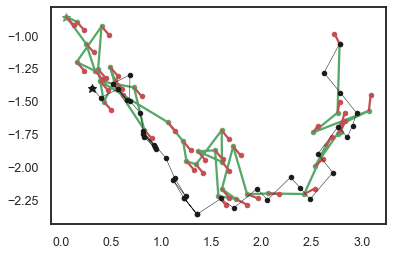

In [41]:
t = 40

### Plot filtered ###
plt.plot(xhat_filt_lem[:, 0], xhat_filt_lem[:, 1], 'g.-') # T = 1:t
plt.plot(xhat_filt_lem[1, 0], xhat_filt_lem[1, 1], 'g*') # T = 1:t

### Iterate through t and plot predicted ###
for it in range(t-2): 
    plt.plot([xhat_filt_lem[it, 0], xhat_pred_lem[it, 0]], 
             [xhat_filt_lem[it, 1], xhat_pred_lem[it, 1]], 
             'r-')
    plt.plot(xhat_pred_lem[it, 0], xhat_pred_lem[it, 1], 'r.')

### smoothed data ####
plt.plot(x[1:t, 0], x[1:t, 1], 'k.-', linewidth=.5) # T = 1:t
plt.plot(x[1, 0], x[1, 1], 'k*') # T = 1:t


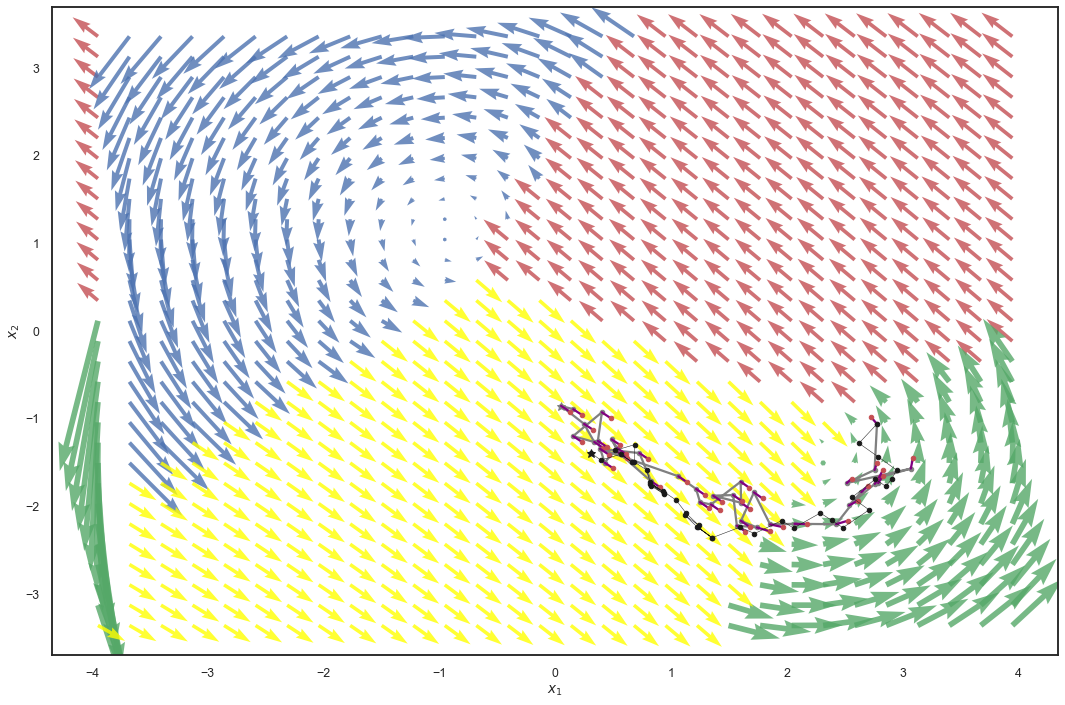

In [45]:
f, ax = plt.subplots(figsize=(15, 10))
colors = ['r','b','g','yellow']
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)


t = 40
### Plot filtered ###
plt.plot(xhat_filt_lem[:, 0], xhat_filt_lem[:, 1], '.-', color='gray') # T = 1:t
plt.plot(xhat_filt_lem[1, 0], xhat_filt_lem[1, 1], '*' , color='gray') # T = 1:t

### Iterate through t and plot predicted ###
for it in range(t-2): 
    plt.plot([xhat_filt_lem[it, 0], xhat_pred_lem[it, 0]], 
             [xhat_filt_lem[it, 1], xhat_pred_lem[it, 1]], 
             '-', color='purple')
    plt.plot(xhat_pred_lem[it, 0], xhat_pred_lem[it, 1], 'r.')

### smoothed data ####
plt.plot(x[1:t, 0], x[1:t, 1], 'k.-', linewidth=.5) # T = 1:t
plt.plot(x[1, 0], x[1, 1], 'k*') # T = 1:t



In [46]:
zhat_filt_lem

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [24]:
Pt.shape

(38, 4, 4)

In [25]:
Pt[-1, 0, :]

array([-9.46661899e+00, -7.00457762e+01, -2.45810856e-04, -8.68923962e+00])

In [26]:
Pt[0, 0, :]

array([-6.75573283e+00, -3.34699384e+01, -1.49690350e+01, -1.16518046e-03])

In [48]:
import os

In [50]:
os.version

AttributeError: module 'os' has no attribute 'version'

In [51]:
len(y)

1000

In [54]:
rslds_lem.initialize([y, y])

In [55]:
_, post = rslds_lem.fit([y, y, y], method="laplace_em", 
                             variational_posterior="structured_meanfield",
                             num_iters=10, initialize=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
tmp = post.discrete_expectations

In [59]:
len(tmp)

3

In [60]:
len(tmp[0])

3

In [61]:
tmp[0]

(array([[2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01],
        [1.96622785e-10, 5.01270728e-03, 1.88179227e-19, 9.94987293e-01],
        [1.46191343e-07, 1.53701154e-03, 2.19004633e-16, 9.98462842e-01],
        ...,
        [4.39135220e-16, 8.23335512e-21, 1.15930987e-07, 9.99999884e-01],
        [1.99897566e-19, 1.25280102e-23, 1.01469454e-08, 9.99999990e-01],
        [2.80405706e-21, 1.81721142e-20, 2.76193201e-09, 9.99999997e-01]]),
 array([[[4.91556963e-11, 1.25317682e-03, 4.70448067e-20, 2.48746823e-01],
         [4.91556963e-11, 1.25317682e-03, 4.70448067e-20, 2.48746823e-01],
         [4.91556963e-11, 1.25317682e-03, 4.70448067e-20, 2.48746823e-01],
         [4.91556963e-11, 1.25317682e-03, 4.70448067e-20, 2.48746823e-01]],
 
        [[2.87445490e-17, 3.02211490e-13, 4.30613009e-26, 1.96320545e-10],
         [7.32814409e-10, 7.70458894e-06, 1.09780612e-18, 5.00500196e-03],
         [2.75101739e-26, 2.89233643e-22, 4.12121225e-35, 1.87889966e-19],
         [1.4

In [62]:
discrete_expectations

NameError: name 'discrete_expectations' is not defined